In [21]:
# Moviepy and other video processing instalations:

!pip install --upgrade pip
!pip install moviepy
!pip install imageio-ffmpeg

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (19.1)


In [22]:
# import everything that is required

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
# Get the distortion coefficient and camera matrix using pickle
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [53]:
# initialisation values:
fit_pol_win_lane=0
fit_pol_prev_lane=0
left_fit = np.array([ 1, 1, 0])
right_fit = np.array([ 1, 1, 0])
    

In [54]:
#test run retrival of values from pickle
#print("MTX=",mtx)
#print("DIST=",dist)

In [55]:
#Read image
#Image_read = mpimg.imread('test_images/test1.jpg')
#img_size= (Image_read.shape[1], Image_read.shape[0])
#Image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [56]:
############################
# 1. Color Binary
############################
#Source: Quiz from lessons and additional conditions

def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
    img = np.copy(img)
    img_size= (img.shape[1], img.shape[0])
    # binary image from grayscale
    Image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_gray = np.zeros_like(Image_gray)
    binary_gray [(Image_gray > gray_thresh[0]) & (Image_gray <= gray_thresh[1])] = 1

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
     # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
    # Stack each channel)
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( binary_combined, binary_combined, binary_combined)) * 255
    color_binary =color_binary[:,:,2]
    return color_binary
    
#Image_CB = color_binary(Image_read)



#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(Image_read)
#ax1.set_title('Original Image', fontsize=40)
#ax2.imshow(Image_CB)
#ax2.set_title('Undistorted Binary Image', fontsize=40)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [57]:
#################################################################
# 2. Unwarp and transform image#
#################################################################
#source: Quiz from lessons


def corners_unwarp(img, mtx= dist_pickle["mtx"], dist= dist_pickle["dist"]):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #define source and destination
    
    img_size= (img.shape[1], img.shape[0])
    
    # defining the 4 points of the source
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_bottom_s = (230, ysize -50)
    left_top_s = (xsize / 2 - 55, ysize / 2 +90)
    right_bottom_s = (xsize - 235, ysize -50)
    right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
    src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
    # Points were physicaly measured on the image Straight_lines1
    #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)])
   
    # defining the 4 points of the destination
    left_bottom_d = (320, ysize)
    left_top_d = (320, 0)
    right_bottom_d = (xsize - 340, ysize )
    right_top_d = (xsize - 340 , 0)
    dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
    # Since the reference is a straight lane the transformed image has tpo be a rectangle
    # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    M_inv = cv2.getPerspectiveTransform(dst, src) # Required for reverse transformation of lane
    
    return warped, M, M_inv

#dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
#mtx = dist_pickle["mtx"]
#dist = dist_pickle["dist"]
#Image_top_down, perspective_M, Inverse_M = corners_unwarp(Image_CB)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(Image_read)
#ax1.set_title('Original Image', fontsize=40)
#ax2.imshow(Image_top_down)
#print(Image_top_down.size)
#ax2.set_title('Undistorted and Warped Binary Image', fontsize=40)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [58]:
#################################################################
# -3.1- sliding window method of finding lanes-##
#################################################################
#source: Quiz from lessons


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines    
    midpoint = np.int(histogram.shape[0]//2)
        
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #print(histogram))
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    #print("leftx is",leftx, "lefty is",lefty, "rightx is",rightx, "righty is",righty)
    # Were right and left lane found
    if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
        fit_pol_win_lane=0 # lane not found
    else:
        fit_pol_win_lane=1 # lane found

    #print ("fit_pol_win_lane value is ",fit_pol_win_lane)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print("left fit is",left_fit, "right fit is",right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        #print ("left lane Index",left_fitx, ploty)
        #print ("right lane Index",right_fitx, ploty)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


        ## Visualization ##
        # Colors in the left and right lane regions
        #out_img[lefty, leftx] = [255, 0, 0] # demarkating Left lane is not required
        #out_img[righty, rightx] = [0, 0, 255]# demarkating right lane is not required

        #Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow') #ploting the lanes is not required
        #plt.plot(right_fitx, ploty, color='yellow') #ploting the lanes is not required

    return left_fit,right_fit,fit_pol_win_lane


#left_win_fit_co,right_win_fit_co,fit_pol_win_lane  = fit_polynomial(Image_top_down)
#print ("Coefficients of left polynomial A,B and C",left_win_fit_co)
#print ("coefficients of right polynomial A,B and C",right_win_fit_co)
#print ("left lane Index",left_win_fitx, ploty_win)
#print ("right lane Index",right_win_fitx, ploty_win)
#print ("fit_pol_prev_lane value is ",fit_pol_prev_lane, "fit_pol_win_lane value is",fit_pol_win_lane)
#plt.imshow(Image_fit_window)# ploting the image is not required


In [59]:
#######################################################################
# -3.2- find lane from previous-##
#######################################################################

# Load our image - this should be a new frame since last time!

#[ 2.76657214e-04 -5.36742976e-01  6.32736498e+02]
#[ 1.66092155e-04 -3.23694165e-01  1.12134046e+03]
# Polynomial fit values from the previous frame
# Manually feeding to check
#left_fit = np.array([ 2.76657214e-04, -5.36742976e-01,  6.32736498e+02])
#right_fit = np.array([ 1.66092155e-04, -3.23694165e-01,  1.12134046e+03])
#if (fit_pol_win_lane ==1):
#    left_fit = left_win_fit_co
#    right_fit = right_win_fit_co
#else:
#    left_fit = left_prev_fit_co
#    right_fit = right_prev_fit_co


def fit_poly(img_shape, leftx, lefty, rightx, righty):
        
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print("leftx is",leftx, "lefty is",lefty, "rightx is",rightx, "righty is",righty)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Were right and left lane found
    if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
        fit_pol_prev_lane=0 # lane not found
    else:
        fit_pol_prev_lane=1 # lane found
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0] # dont need to visualise the right lane points
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]# dont need to visualise the left lane points

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow') # don't need to visualise left lane
    #plt.plot(right_fitx, ploty, color='yellow')# dont need to visualise right lane
    ## End visualization steps ##
 
    ### calculate the radius of curvature###
    
    #return result, right_fitx, ploty, left_fit, right_fit # dont need return image
    return left_fit, right_fit,fit_pol_prev_lane

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#image_fit_prev,left_prev_fitx,right_prev_fitx,ploty_prev,left_prev_fit_co,right_prev_fit_co = search_around_poly(Image_top_down)
#left_prev_fit_co,right_prev_fit_co, fit_pol_prev_lane = search_around_poly(Image_top_down)
# View your output
#print ("Coefficients of left polynomial A,B and C",left_prev_fit_co)
#print ("coefficients of right polynomial A,B and C",right_prev_fit_co)
#print ("left lane Index",left_prev_fitx, ploty_prev)
#print ("right lane Index",right_prev_fitx, ploty_prev)
#print ("fit_pol_prev_lane value is ",fit_pol_prev_lane, "fit_pol_win_lane value is",fit_pol_win_lane)
#plt.imshow(image_fit_prev )



In [60]:
####################################################################################
#-4-  coordinates and coefficients of the polynomial based on which method is used--##
####################################################################################
def choose_method(fit_pol_win_lane,fit_pol_prev_lane,left_win_fit_co,right_win_fit_co,left_prev_fit_co,right_prev_fit_co):
    
    if (fit_pol_prev_lane ==1 or (fit_pol_prev_lane ==1 and fit_pol_win_lane ==1)):
        left_fit = left_prev_fit_co
        right_fit= right_prev_fit_co

    #elif (fit_pol_prev_lane ==1 and fit_pol_win_lane ==1):
        #left_fit = left_prev_fit_co
        #right_fit= right_prev_fit_co

    elif (fit_pol_prev_lane ==0 and fit_pol_win_lane ==1):
        left_fit = left_win_fit_co
        right_fit= right_win_fit_co

    else:
        left_fit = left_win_fit_co
        right_fit= right_win_fit_co 

    return left_fit, right_fit
#if left_fit.all() ==0|right_fit.all() ==0:
    #lines_fit=0
#else:
    #lines_fit=1


In [61]:
# Test run co-efficients
print("co-efficients of the left polynomial", left_fit,
      "co-efficients of the right polynomial", right_fit)

co-efficients of the left polynomial [1 1 0] co-efficients of the right polynomial [1 1 0]


In [62]:
######################################
#-5.1-- Measuring Curvature I--##
#-5.2--Calculate offset--#
######################################

def cal_curve(img,leftx,rightx):
    
    img_shape=img.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0]) # generate equaly spaced Y co-ordinates
    #print(ploty)
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    #print(ploty.shape[0])
   
    left_fitx = leftx[0]*ploty**2 + leftx[1]*ploty + leftx[2] #fit left polynomial
    right_fitx = rightx[0]*ploty**2 + rightx[1]*ploty + rightx[2]#fit left polynomial
    # Define conversions in x and y from pixels space to meters as was used in the classes
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension (actual lane is approximately 3.7 m wide)

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty) 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2) # derive thecoefficients of the polynomial on the real left curve
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)# derive thecoefficients of the polynomial on the real right curve
    
    # Calculate the new radii of curvature using the formula R=[(1+(2Ay+B)²)³/2]/|2A|
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]) # curve radius left
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])# curve radius right
    
    ############################
    # - 5.2 Calculate offset-##
    ############################

    # Calculate mid point of image in the x-direction (refernce midpoint of the vehicle)
    Mid_point_img = img_shape[1]//2
    # calculate mid point of lane
    Mid_point_lane = (left_fitx[-1] + right_fitx[-1])/2
    # calculate offset
    ofs = (Mid_point_img- Mid_point_lane)* xm_per_pix
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad, ofs, Mid_point_img, Mid_point_lane


In [63]:
# Test run curvatures and offset
#left_c,right_c,offset, image_m, Vehicle_m = cal_curve(Image_top_down,left_fit,right_fit)
#print ("right lane curvature is",right_c,"m" )
#print ("left lane curvature is",left_c,"m" )
#print ("vehicle midpoint is",Vehicle_m,"pixel" )
#print ("Lane midpoint is",image_m,"pixel" )
#print ("Offset from center of the vehicle is",offset,"m" )

In [64]:
########################################################################
# - 6. plot the reverse transformed polynomial on the original image -##
########################################################################

def rev_transform(img, warped_img, M_inv, left_fit, right_fit):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] #fit left polynomial
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]#fit left polynomial
    
    # reverse transform the polynomial on the originalimage

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (50,150,200))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    reverse_warp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, reverse_warp, 0.3, 0)


In [65]:
#Test run lane detection 
#reverse_warp= rev_transform (Image_read, Image_top_down, Inverse_M, left_fit, right_fit)
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(Image_read)
#ax1.set_title('Original Image', fontsize=40)
#ax2.imshow(reverse_warp)
#ax2.set_title('Detected lane', fontsize=40)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [66]:
###############################################
#- 7. Print curvature and offset on to image-##
###############################################
#source:https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2

def Print_on_img(img, left_c, right_c,ofs):
    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(left_c), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(right_c), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(ofs), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img



In [67]:
#Test run final image
#Image_final = Print_on_img(reverse_warp, left_c, right_c,offset)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(Image_read)
#ax1.set_title('Original Image', fontsize=40)
#ax2.imshow(Image_final)
#ax2.set_title('final image', fontsize=40)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [70]:
    def Image_process(image):
        Image_CB = color_binary(image)
        Image_top_down,perspective_M, Inverse_M =corners_unwarp(Image_CB)
        left_win_fit_co,right_win_fit_co,fit_pol_win_lane  = fit_polynomial(Image_top_down)
        left_prev_fit_co,right_prev_fit_co, fit_pol_prev_lane = search_around_poly(Image_top_down)
        left_fit, right_fit=choose_method (fit_pol_win_lane,fit_pol_prev_lane,left_win_fit_co,right_win_fit_co,left_prev_fit_co,right_prev_fit_co)
        left_c,right_c,offset, image_m, Vehicle_m = cal_curve(Image_top_down,left_fit,right_fit)
        reverse_warp= rev_transform (image, Image_top_down, Inverse_M, left_fit, right_fit)
        image_final = Print_on_img(reverse_warp, left_c, right_c,offset)
       
        return image_final


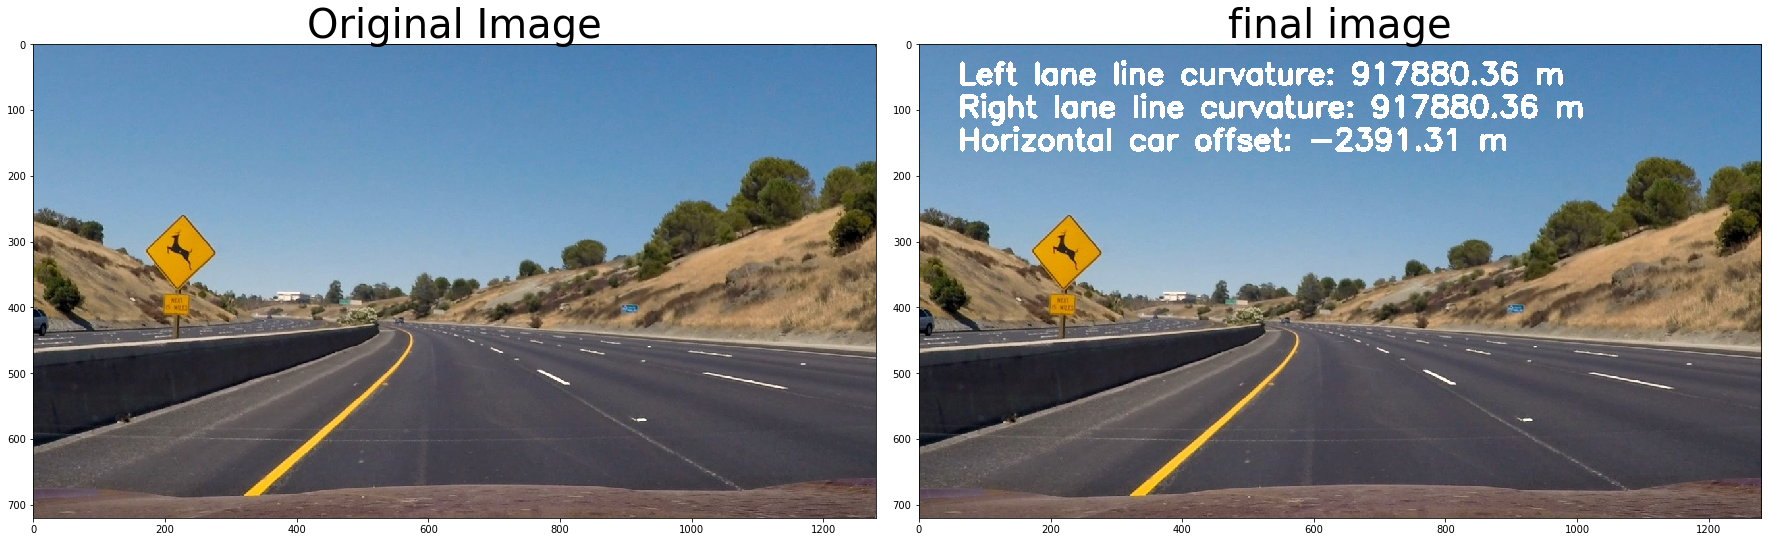

In [71]:
#Test run final image
Image_1 = mpimg.imread('test_images/test2.jpg')
Image_final = Image_process(Image_1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Image_1)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(Image_final)
ax2.set_title('final image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [73]:
white_output = 'project_video_Solution_SK_new.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(Image_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(white_output))

[MoviePy] >>>> Building video project_video_Solution_SK_new.mp4
[MoviePy] Writing video project_video_Solution_SK_new.mp4



 24%|██▍       | 301/1261 [01:01<03:22,  4.75it/s]


TypeError: expected non-empty vector for x

In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


In [ ]:
    def Image_process(image):
        Image_CB = color_binary(image)
        Image_top_down,perspective_M, Inverse_M =corners_unwarp(Image_CB)
        if lines_fit==0:
            left_win_fit_co,right_win_fit_co,fit_pol_win_lane  = fit_polynomial(Image_top_down)
            #left_prev_fit_co.all() =0
            #right_prev_fit_co.all()=0
            #fit_pol_prev_lane=0
        else:
            #left_win_fit_co.all()=0
            #right_win_fit_co.all()=0
            #fit_pol_win_lane=0
            left_prev_fit_co,right_prev_fit_co, fit_pol_prev_lane = search_around_poly(Image_top_down)
        left_fit, right_fit=choose_method (fit_pol_win_lane,fit_pol_prev_lane,left_win_fit_co,right_win_fit_co,left_prev_fit_co,right_prev_fit_co)
        left_c,right_c,offset, image_m, Vehicle_m = cal_curve(Image_top_down,left_fit,right_fit)
        reverse_warp= rev_transform (Image_read, Image_top_down, Inverse_M, left_fit, right_fit)
        Image_final = Print_on_img(reverse_warp, left_c, right_c,offset)
        return image_final

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
white_output = 'project_video_Solution_SK_new.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(Image_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(white_output))

In [ ]:
#####################################
#- Stitch togeather all 7 subunits-##
#####################################

#Source: https://micropyramid.com/blog/understand-self-and-__init__-method-in-python-class/
#source:https://stackoverflow.com/questions/12646326/calling-a-class-function-inside-of-init
############################
# 1. Color Binary
############################
#Source: Quiz from lessons and additional conditions

def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
    img = np.copy(img)
    img_size= (Image_read.shape[1], Image_read.shape[0])
    # binary image from grayscale
    Image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_gray = np.zeros_like(Image_gray)
    binary_gray [(Image_gray > gray_thresh[0]) & (Image_gray <= gray_thresh[1])] = 1

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
     # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
    # Stack each channel)
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( binary_combined, binary_combined, binary_combined)) * 255
    color_binary =color_binary[:,:,2]
    return color_binary
    
Image_CB = color_binary(Image_read)
#################################################################
# 2. Unwarp and transform image#
#################################################################
#source: Quiz from lessons


def corners_unwarp(img, mtx= dist_pickle["mtx"], dist= dist_pickle["dist"]):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #define source and destination
    
    # defining the 4 points of the source
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_bottom_s = (230, ysize -50)
    left_top_s = (xsize / 2 - 55, ysize / 2 +90)
    right_bottom_s = (xsize - 235, ysize -50)
    right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
    src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
    # Points were physicaly measured on the image Straight_lines1
    #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)])
   
    # defining the 4 points of the destination
    left_bottom_d = (320, ysize)
    left_top_d = (320, 0)
    right_bottom_d = (xsize - 340, ysize )
    right_top_d = (xsize - 340 , 0)
    dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
    # Since the reference is a straight lane the transformed image has tpo be a rectangle
    # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    M_inv = cv2.getPerspectiveTransform(dst, src) # Required for reverse transformation of lane
    
    return warped, M, M_inv

#dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
#mtx = dist_pickle["mtx"]
#dist = dist_pickle["dist"]
Image_top_down, perspective_M, Inverse_M = corners_unwarp(Image_CB)

#################################################################
# -3.1- sliding window method of finding lanes-##
#################################################################
#source: Quiz from lessons


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines    
    midpoint = np.int(histogram.shape[0]//2)
        
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #print(histogram))
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    #print("leftx is",leftx, "lefty is",lefty, "rightx is",rightx, "righty is",righty)
    # Were right and left lane found
    if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
        fit_pol_win_lane=0 # lane not found
    else:
        fit_pol_win_lane=1 # lane found

    #print ("fit_pol_win_lane value is ",fit_pol_win_lane)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print("left fit is",left_fit, "right fit is",right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        #print ("left lane Index",left_fitx, ploty)
        #print ("right lane Index",right_fitx, ploty)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


        ## Visualization ##
        # Colors in the left and right lane regions
        #out_img[lefty, leftx] = [255, 0, 0] # demarkating Left lane is not required
        #out_img[righty, rightx] = [0, 0, 255]# demarkating right lane is not required

        #Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow') #ploting the lanes is not required
        #plt.plot(right_fitx, ploty, color='yellow') #ploting the lanes is not required

    return left_fit,right_fit,fit_pol_win_lane


left_win_fit_co,right_win_fit_co,fit_pol_win_lane  = fit_polynomial(Image_top_down)



In [ ]:
white_output = 'project_video_Solution_SK_new.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
Image_initial = Adv_lane_det()
white_clip = clip1.fl_image(Image_initial) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(white_output))

In [ ]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

In [ ]:
to display:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [ ]:
##################################################################
# 1. unwarp and transform
# 2. Transform Image into Grayscale
# 3. Binary image of the Read image
# 4. experiments on the binary image
# 5. finding lanes using sliding windows
#---sub Model: Working Sliding window-#
    
##################################################################
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

# Refer to chessboard_corner for the calculation of the camera matrix and the distortion matrix#
# serealise the matrix using pickle (stored under camera_cal/wide_dist_pickle.p)#
# retrive the distortion and camera matrix from pickle#

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
image_read = mpimg.imread('test_images/straight_lines1.jpg')
img_size= (image_read.shape[1], image_read.shape[0])
# grayscvale the image
#image_gray = cv2.cvtColor(image_read, cv2.COLOR_RGB2GRAY)

# color binary

def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
    img = np.copy(img)
    
    # binary image from grayscale
    image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_gray = np.zeros_like(image_gray)
    binary_gray [(image_gray > gray_thresh[0]) & (image_gray <= gray_thresh[1])] = 1

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
     # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
    # Stack each channel)
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( binary_combined,binary_combined,binary_combined)) * 255
    return color_binary
    
image_CB = color_binary(image_read)
image_CB= image_CB[:,:,2]

#undistort image using the values retrived from pickle
def corners_unwarp(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #define source and destination
    
    # defining the 4 points of the source
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_bottom_s = (230, ysize -50)
    left_top_s = (xsize / 2 - 55, ysize / 2 +90)
    right_bottom_s = (xsize - 235, ysize -50)
    right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
    src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
    #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)])
   
    # defining the 4 points of the destination
    left_bottom_d = (320, ysize)
    left_top_d = (320, 0)
    right_bottom_d = (xsize - 340, ysize )
    right_top_d = (xsize - 345 , 0)
    dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
    # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M

Image_top_down, perspective_M = corners_unwarp(image_CB, mtx, dist)

#########################################################################
##---- Fit sliding windows----------------####
#########################################################################

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
   
    #print(histogram))
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print (left_fit)
    #print (right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


Image_fit_window = fit_polynomial(Image_top_down)

plt.imshow(Image_fit_window)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(image_read)
# ax1.imshow(image_gray)# use this to display image in gray
#ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(Image_top_down)
#ax2.set_title('Gray scale Undistorted and Warped Image', fontsize=30)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#code to save image
#image_name= test1.split('/')
#resultImageName = 'result_test6_lane_from_sliding_window.jpg'
#plt.savefig(os.path.join('output_images/polynomial on the transformed image' , resultImageName))

In [ ]:
##################################################################
# 1. unwarp and transform
# 2. Transform Image into Grayscale
# 3. Binary image of the Read image
# 4. experiments on the binary image
# 5. discard finding lanes using sliding windows
# 6. finding lanes using search from prior
#---sub Model: Working lane finding in the area of prior lane#
    
##################################################################
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

# Refer to chessboard_corner for the calculation of the camera matrix and the distortion matrix#
# serealise the matrix using pickle (stored under camera_cal/wide_dist_pickle.p)#
# retrive the distortion and camera matrix from pickle#

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
image_read = mpimg.imread('test_images/test1.jpg')
img_size= (image_read.shape[1], image_read.shape[0])
print(img_size)
# grayscvale the image
#image_gray = cv2.cvtColor(image_read, cv2.COLOR_RGB2GRAY)

# color binary

def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
    img = np.copy(img)
    
    # binary image from grayscale
    image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_gray = np.zeros_like(image_gray)
    binary_gray [(image_gray > gray_thresh[0]) & (image_gray <= gray_thresh[1])] = 1

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
     # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
    # Stack each channel)
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( binary_combined,binary_combined,binary_combined)) * 255
    return color_binary
    
image_CB = color_binary(image_read)
image_CB= image_CB[:,:,2]

#undistort image using the values retrived from pickle
def corners_unwarp(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #define source and destination
    
    # defining the 4 points of the source
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_bottom_s = (230, ysize -50)
    left_top_s = (xsize / 2 - 55, ysize / 2 +90)
    right_bottom_s = (xsize - 235, ysize -50)
    right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
    src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
    #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)])
   
    # defining the 4 points of the destination
    left_bottom_d = (320, ysize)
    left_top_d = (320, 0)
    right_bottom_d = (xsize - 340, ysize )
    right_top_d = (xsize - 345 , 0)
    dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
    # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    #inverse Transform
    M_Inv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, M, M_Inv

Image_top_down, perspective_M, Inverse_M = corners_unwarp(image_CB, mtx, dist)

#######################################################################
# --- find lane from previous-----#####
#######################################################################

# Load our image - this should be a new frame since last time!

#[ 2.76657214e-04 -5.36742976e-01  6.32736498e+02]
#[ 1.66092155e-04 -3.23694165e-01  1.12134046e+03]
# Polynomial fit values from the previous frame
# Manually feeding to check
left_fit = np.array([ 2.76657214e-04, -5.36742976e-01,  6.32736498e+02])
right_fit = np.array([ 1.66092155e-04, -3.23694165e-01,  1.12134046e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Were right and left lane found
    if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
        fit_pol_lane=0 # lane not found
    else:
        fit_pol_lane=1 # lane found
    
    print ("fit_pol_lane value is ",fit_pol_lane)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
 
    ### calculate the radius of curvature###

    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
image_fit_prev = search_around_poly(Image_top_down)
# View your output
plt.imshow(image_fit_prev )

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(image_read)
# ax1.imshow(image_gray)# use this to display image in gray
#ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(Image_top_down)
#ax2.set_title('Gray scale Undistorted and Warped Image', fontsize=30)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#code to save image
#image_name= test1.split('/')
#resultImageName = 'result_test6_lane region.jpg'
#plt.savefig(os.path.join('output_images/polynomial on the transformed image' , resultImageName))

In [ ]:
##################################################################
# 1. unwarp and transform
# 2. Transform Image into Grayscale
# 3. Binary image of the Read image
# 4. experiments on the binary image
# 5. discard finding lanes using sliding windows
# 6. finding lanes using search from prior
# 7. Calculate lane radius
#---sub Model: Working lane finding in the area of prior lane with radius calculation#
    
##################################################################
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

# Refer to chessboard_corner for the calculation of the camera matrix and the distortion matrix#
# serealise the matrix using pickle (stored under camera_cal/wide_dist_pickle.p)#
# retrive the distortion and camera matrix from pickle#

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
image_read = mpimg.imread('test_images/test1.jpg')
img_size= (image_read.shape[1], image_read.shape[0])
print(img_size)
# grayscvale the image
#image_gray = cv2.cvtColor(image_read, cv2.COLOR_RGB2GRAY)

# color binary

def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
    img = np.copy(img)
    
    # binary image from grayscale
    image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_gray = np.zeros_like(image_gray)
    binary_gray [(image_gray > gray_thresh[0]) & (image_gray <= gray_thresh[1])] = 1

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
     # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
    # Stack each channel)
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( binary_combined,binary_combined,binary_combined)) * 255
    return color_binary
    
image_CB = color_binary(image_read)
image_CB= image_CB[:,:,2]

#undistort image using the values retrived from pickle
def corners_unwarp(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #define source and destination
    
    # defining the 4 points of the source
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_bottom_s = (230, ysize -50)
    left_top_s = (xsize / 2 - 55, ysize / 2 +90)
    right_bottom_s = (xsize - 235, ysize -50)
    right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
    src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
    #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)])
   
    # defining the 4 points of the destination
    left_bottom_d = (320, ysize)
    left_top_d = (320, 0)
    right_bottom_d = (xsize - 340, ysize )
    right_top_d = (xsize - 345 , 0)
    dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
    # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    #inverse Transform
    M_Inv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, M, M_Inv

Image_top_down, perspective_M, Inverse_M = corners_unwarp(image_CB, mtx, dist)

#######################################################################
# --- find lane from previous-----#####
#######################################################################

# Load our image - this should be a new frame since last time!

#[ 2.76657214e-04 -5.36742976e-01  6.32736498e+02]
#[ 1.66092155e-04 -3.23694165e-01  1.12134046e+03]
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.76657214e-04, -5.36742976e-01,  6.32736498e+02])
right_fit = np.array([ 1.66092155e-04, -3.23694165e-01,  1.12134046e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    print ("leftx values",leftx,"lefty values", lefty,"rightx values" , rightx, "righty values", righty)
    # Were right and left lane found with this method
    if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
        fit_pol_lane=0 # lane not found
    else:
        fit_pol_lane=1 # lane found
    
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    print(left_fitx.shape[0])
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
 

    return result ,left_fitx, right_fitx

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
image_fit_prev, left_x, right_x = search_around_poly(Image_top_down)
# View your output
plt.imshow(image_fit_prev )

### calculate the radius of curvature###

def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[1] - 1, img_shape[1])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    print(ploty.shape[0])
    print(leftx.shape[0])
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

img_shape_fit = (Image_top_down.shape[1], Image_top_down.shape[0])
left_c, right_c = curvature_radius (left_x, right_x, img_shape_fit)
print("left radius is",left_c,"m")
print("right radius is",right_c,"m")
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(image_read)
# ax1.imshow(image_gray)# use this to display image in gray
#ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(Image_top_down)
#ax2.set_title('Gray scale Undistorted and Warped Image', fontsize=30)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#code to save image
#image_name= test1.split('/')
#resultImageName = 'result_test6_lane region.jpg'
#plt.savefig(os.path.join('output_images/polynomial on the transformed image' , resultImageName))

In [ ]:
##################################################################
# 1. unwarp and transform
# 2. Transform Image into Grayscale
# 3. Binary image of the Read image
# 4. experiments on the binary image
# 5. discard finding lanes using sliding windows
# 6. finding lanes using search from prior
# 7. Calculate lane radius
# 8. draw the lane back to the original image from the warped image
#---sub Model: everything works on the image as required#
    
##################################################################
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

# Refer to chessboard_corner for the calculation of the camera matrix and the distortion matrix#
# serealise the matrix using pickle (stored under camera_cal/wide_dist_pickle.p)#
# retrive the distortion and camera matrix from pickle#

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
image_read = mpimg.imread('test_images/test1.jpg')
img_size= (image_read.shape[1], image_read.shape[0])
print(img_size)
# grayscvale the image
#image_gray = cv2.cvtColor(image_read, cv2.COLOR_RGB2GRAY)

# color binary

def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
    img = np.copy(img)
    
    # binary image from grayscale
    image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_gray = np.zeros_like(image_gray)
    binary_gray [(image_gray > gray_thresh[0]) & (image_gray <= gray_thresh[1])] = 1

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
     # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
    # Stack each channel)
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( binary_combined,binary_combined,binary_combined)) * 255
    return color_binary
    
image_CB = color_binary(image_read)
image_CB= image_CB[:,:,2]

#undistort image using the values retrived from pickle
def corners_unwarp(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #define source and destination
    
    # defining the 4 points of the source
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_bottom_s = (230, ysize -50)
    left_top_s = (xsize / 2 - 55, ysize / 2 +90)
    right_bottom_s = (xsize - 235, ysize -50)
    right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
    src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
    #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)])
   
    # defining the 4 points of the destination
    left_bottom_d = (320, ysize)
    left_top_d = (320, 0)
    right_bottom_d = (xsize - 340, ysize )
    right_top_d = (xsize - 345 , 0)
    dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
    # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    #inverse Transform needed when the lane marked on the warped image has to be brought back to the camera perspective
    M_Inv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, M, M_Inv

Image_top_down, perspective_M, Inverse_M = corners_unwarp(image_CB, mtx, dist)

#######################################################################
# --- find lane from previous-----#####
#######################################################################

# Load our image - this should be a new frame since last time!

#[ 2.76657214e-04 -5.36742976e-01  6.32736498e+02]
#[ 1.66092155e-04 -3.23694165e-01  1.12134046e+03]
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = left_fit_prev
right_fit = right_fit_prev

def fit_poly(img_shape, leftx, lefty, rightx, righty):

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
        # Were right and left lane found with this method
    if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
        fit_pol_lane=0 # lane not found
    else:
        fit_pol_lane=1 # lane found
        
    print ("fit_pol_lane value is ",fit_pol_lane)

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    print(left_fitx.shape[0])
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
 

    return result ,left_fitx, right_fitx

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
image_fit, left_x, right_x = search_around_poly(Image_top_down)
# View your output
plt.imshow(image_fit)

#########################################################################
##---- Fit sliding windows----------------####
#########################################################################

def find_lane_pixels(binary_warped):

    if fit_pol_lane ==0: # lanes found in the other method
        return leftx.fill(0), lefty.fill(0), rightx.fill(0), righty.fill(0), out_img ==False # then return zero
    else: #else use the sliding window method
        # Take a histogram of the bottom half of the image    
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)

        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        #print(histogram))
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

            # Were right and left lane found with this method
        if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
            fit_win_lane=0 # lane not found
        else:
            fit_win_lane=1 # lane found

        print ("fit_win_lane value is ",fit_win_lane)

        return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print (left_fit)
    #print (right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx

Image_fit, left_fit_prev, right_fit_prev,left_fitx, right_fitx = fit_polynomial(Image_top_down)

### calculate the radius of curvature###

def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[1] - 1, img_shape[1])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    print(ploty.shape[0])
    print(leftx.shape[0])
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

img_shape_fit = (Image_top_down.shape[1], Image_top_down.shape[0])
left_c, right_c = curvature_radius (left_x, right_x, img_shape_fit)
print("left radius is",left_c,"m")
print("right radius is",right_c,"m")

#############################################
### add the lanes to the original image#####
############################################

def plot_back_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)
ploty = np.linspace(0, Image_top_down.shape[0]-1, Image_top_down.shape[0] )
left_points=(left_fitx, ploty)
right_points=(right_fitx, ploty)
image_lane = plot_back_lane(image_read, Image_top_down, left_points, right_points, Inverse_M )

# Plot the results
#plt_images(image_read, 'Raw image', image_lane, 'Lane detected')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_read)
ax1.set_title('Raw Image', fontsize=30)
ax2.imshow(image_lane)
ax2.set_title('Image with detected lane', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#code to save image
#image_name= test1.split('/')
#resultImageName = 'result_test6_lane region.jpg'
#plt.savefig(os.path.join('output_images/polynomial on the transformed image' , resultImageName))

In [ ]:
# Moviepy and other video processing instalations:

!pip install --upgrade pip
!pip install moviepy
!pip install imageio-ffmpeg

In [ ]:
##################################################################
# 1. unwarp and transform
# 2. Transform Image into Grayscale
# 3. Binary image of the Read image
# 4. experiments on the binary image
# 5. discard finding lanes using sliding windows
# 6. finding lanes using search from prior
# 7. Calculate lane radius
# 8. draw the lane back to the original image from the warped image
# 9. clean up everything unwanted (print, plot and so on) and prepare for the video
# final version#
    
##################################################################

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import math
import pickle
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import moviepy
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Refer to chessboard_corner for the calculation of the camera matrix and the distortion matrix#
# serealise the matrix using pickle (stored under camera_cal/wide_dist_pickle.p)#
# retrive the distortion and camera matrix from pickle#
def adv_lane_det(image_raw):
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    image_read = image_raw
    img_size= (image_read.shape[1], image_read.shape[0])

    # color binary

    def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
        img = np.copy(img)

        # binary image from grayscale
        image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        binary_gray = np.zeros_like(image_gray)
        binary_gray [(image_gray > gray_thresh[0]) & (image_gray <= gray_thresh[1])] = 1

        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

         # Threshold color channel
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
        # Stack each channel)
        #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        color_binary = np.dstack(( binary_combined,binary_combined,binary_combined)) * 255
        return color_binary

    image_CB = color_binary(image_read)

    # The Histogram does not work if it has a 3rd dimension  therfore reduced to single chjanel
    image_CB= image_CB[:,:,2]

    #undistort image using the values retrived from pickle
    def corners_unwarp(img, mtx, dist):
        dst = cv2.undistort(img, mtx, dist, None, mtx)

        #define source and destination
        # defining the 4 points of the source
        xsize = img.shape[1]
        ysize = img.shape[0]
        left_bottom_s = (230, ysize -50)
        left_top_s = (xsize / 2 - 55, ysize / 2 +90)
        right_bottom_s = (xsize - 235, ysize -50)
        right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
        src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
        #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)]) derived from Straight_lines1.jpg manualy (trial and error)

        # defining the 4 points of the destination
        left_bottom_d = (320, ysize)
        left_top_d = (320, 0)
        right_bottom_d = (xsize - 340, ysize )
        right_top_d = (xsize - 345 , 0)
        dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
        # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)]) deduced for Straight_lines1.jpg manualy

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

        #inverse Transform needed when the lane marked on the warped image has to be brought back to the camera perspective
        M_Inv = cv2.getPerspectiveTransform(dst, src)

        return warped, M, M_Inv

    Image_top_down, perspective_M, Inverse_M = corners_unwarp(image_CB, mtx, dist)

    #########################################################################
    ##---- Fit sliding windows----------------####
    #########################################################################

    def find_lane_pixels(binary_warped):
        # Take a histogram of the bottom half of the image

        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)

        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        #print(histogram))
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image--> not required
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            #(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),
            #(win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img


    def fit_polynomial(binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        return out_img, left_fit, right_fit, left_fitx, right_fitx

    Image_fit, left_fit_prev, right_fit_prev,left_fitx, right_fitx = fit_polynomial(Image_top_down)
    #######################################################################
    # --- find lane from previous-----#####
    #######################################################################

    # Load our image - this should be a new frame since last time!
    # Manual trial
    #[ 2.76657214e-04 -5.36742976e-01  6.32736498e+02]
    #[ 1.66092155e-04 -3.23694165e-01  1.12134046e+03]
    # Polynomial fit values from the previous frame
    # Make sure to grab the actual values from the previous step in your project!
    left_fit = left_fit_prev
    right_fit = right_fit_prev

    def fit_poly(img_shape, leftx, lefty, rightx, righty):

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fitx, right_fitx, ploty

    def search_around_poly(binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])


        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        #print(left_fitx.shape[0])
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##


        return result ,left_fitx, right_fitx, leftx , rightx

    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    #image_fit, left_x, right_x = search_around_poly(Image_top_down)
    # View your output
    #plt.imshow(image_fit)

    ### calculate the radius of curvature###

    def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
        ploty = np.linspace(0, img_shape[1] - 1, img_shape[1])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        # Fit a second order polynomial to pixel positions in each fake lane line
        #print(ploty.shape[0])
        #print(leftx.shape[0])
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 25/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/800 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        y_eval = np.max(ploty)
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        ##Calculate the vehicle offset with the center of the vehicle as the reference
        ## Image mid horizontal position 
        mid_imgx = img_shape[1]//2

        ## Car position with respect to the lane
        car_pos = (leftx[-1] + rightx[-1])/2

        ## Horizontal car offset 
        offset_x = (mid_imgx - car_pos) * xm_per_pix

        # Now our radius of curvature is in meters
        return (left_curverad, right_curverad, offset_x)

    img_shape_fit = (Image_top_down.shape[1], Image_top_down.shape[0])
    left_c, right_c, offset = curvature_radius (left_fitx, right_fitx, img_shape_fit)
    print("left radius is",left_c,"m")
    print("right radius is",right_c,"m")
    print("vehicle offset is",offset,"m")
    #############################################
    ### add the lanes to the original image#####
    ############################################

    def plot_back_lane(img, warped_img, left_points, right_points, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        left_fitx = left_points[0]
        right_fitx = right_points[0]
        ploty = left_points[1]

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 200))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

        # Combine the result with the original image
        return cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    ploty = np.linspace(0, Image_top_down.shape[0]-1, Image_top_down.shape[0] )
    left_points=(left_fitx, ploty)
    right_points=(right_fitx, ploty)
    image_lane = plot_back_lane(image_read, Image_top_down, left_points, right_points, Inverse_M )

    return (image_lane)

white_output = './project_video_SK_after detection.mp4'
clips = VideoFileClip('./project_video.mp4')
line_clips = clips.fl_image(adv_lane_det) 
line_clips.write_videofile(white_output, audio=False)

HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(white_output_improved))

In [ ]:
##################################################################
# 1. unwarp and transform
# 2. Transform Image into Grayscale
# 3. Binary image of the Read image
# 4. experiments on the binary image
# 5. discard finding lanes using sliding windows
# 6. finding lanes using search from prior
# 7. Calculate lane radius
# 8. draw the lane back to the original image from the warped image
# 9. clean up everything unwanted (print, plot and so on) and prepare for the video
# final version#
    
##################################################################

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import math
import pickle
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import moviepy
from matplotlib.patches import Polygon
#from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Refer to chessboard_corner for the calculation of the camera matrix and the distortion matrix#
# serealise the matrix using pickle (stored under camera_cal/wide_dist_pickle.p)#
# retrive the distortion and camera matrix from pickle#
def adv_lane_det(image_raw):
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    image_read = image_raw
    img_size= (image_read.shape[1], image_read.shape[0])

    # color binary

    def color_binary(img,gray_thresh=(230, 255), h_thresh=(230, 255),l_thresh= (240, 255),s_thresh=(150, 255), sx_thresh=(70, 100)):
        img = np.copy(img)

        # binary image from grayscale
        image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        binary_gray = np.zeros_like(image_gray)
        binary_gray [(image_gray > gray_thresh[0]) & (image_gray <= gray_thresh[1])] = 1

        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

         # Threshold color channel
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        binary_combined = (binary_gray)|(sxbinary)|(h_binary)|(l_binary)|(s_binary)
        # Stack each channel)
        #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        color_binary = np.dstack(( binary_combined,binary_combined,binary_combined)) * 255
        return color_binary

    image_CB = color_binary(image_read)

    # The Histogram does not work if it has a 3rd dimension  therfore reduced to single chjanel
    image_CB= image_CB[:,:,2]

    #undistort image using the values retrived from pickle
    def corners_unwarp(img, mtx, dist):
        dst = cv2.undistort(img, mtx, dist, None, mtx)

        #define source and destination
        # defining the 4 points of the source
        xsize = img.shape[1]
        ysize = img.shape[0]
        left_bottom_s = (230, ysize -50)
        left_top_s = (xsize / 2 - 55, ysize / 2 +90)
        right_bottom_s = (xsize - 235, ysize -50)
        right_top_s = (xsize / 2 + 50, ysize / 2 + 90)
        src = np.float32([(left_bottom_s), (left_top_s), (right_top_s), (right_bottom_s)])
        #src = np.float32([(230, 670),( 590, 448),(688, 448),(1050, 670)]) derived from Straight_lines1.jpg manualy (trial and error)

        # defining the 4 points of the destination
        left_bottom_d = (320, ysize)
        left_top_d = (320, 0)
        right_bottom_d = (xsize - 340, ysize )
        right_top_d = (xsize - 345 , 0)
        dst = np.float32([(left_bottom_d), (left_top_d), (right_top_d), (right_bottom_d)])
        # dst = np.float32([(320, 720),(320, 0),(960, 0),(960, 720)]) deduced for Straight_lines1.jpg manualy

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

        #inverse Transform needed when the lane marked on the warped image has to be brought back to the camera perspective
        M_Inv = cv2.getPerspectiveTransform(dst, src)

        return warped, M, M_Inv

    Image_top_down, perspective_M, Inverse_M = corners_unwarp(image_CB, mtx, dist)
    
        #######################################################################
    # --- find lane from previous-----#####
    #######################################################################

    # Load our image - this should be a new frame since last time!
    # Manual trial
    #[ 2.76657214e-04 -5.36742976e-01  6.32736498e+02]
    #[ 1.66092155e-04 -3.23694165e-01  1.12134046e+03]
    # Polynomial fit values from the previous frame
    # Make sure to grab the actual values from the previous step in your project!
    left_fit = left_fit_prev
    right_fit = right_fit_prev

    def fit_poly(img_shape, leftx, lefty, rightx, righty):

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fitx, right_fitx, ploty

    def search_around_poly(binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])


        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Were right and left lane found with this method
        if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
            fit_pol_lane=0 # lane not found
        else:
            fit_pol_lane=1 # lane found

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        #print(left_fitx.shape[0])
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##


        return result ,left_fitx, right_fitx

    #########################################################################
    ##---- Fit sliding windows----------------####
    #########################################################################

    def find_lane_pixels(binary_warped):
        # Take a histogram of the bottom half of the image
        if fit_pol_lane ==0: # lanes found in the other method
            return leftx.fill(0), lefty.fill(0), rightx.fill(0), righty.fill(0), out_img ==False # then return zero
        else: #else use the sliding window method
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            # Create an output image to draw on and visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)

            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            #print(histogram))
            # HYPERPARAMETERS
            # Choose the number of sliding windows
            nwindows = 9
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50

            # Set height of windows - based on nwindows above and image shape
            window_height = np.int(binary_warped.shape[0]//nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated later for each window in nwindows
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                # Draw the windows on the visualization image--> not required
                #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                #(win_xleft_high,win_y_high),(0,255,0), 2) 
                #cv2.rectangle(out_img,(win_xright_low,win_y_low),
                #(win_xright_high,win_y_high),(0,255,0), 2) 

                # Identify the nonzero pixels in x and y within the window #
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices (previously was a list of lists of pixels)
            try:
                left_lane_inds = np.concatenate(left_lane_inds)
                right_lane_inds = np.concatenate(right_lane_inds)
            except ValueError:
                # Avoids an error if the above is not implemented fully
                pass

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]

            # Were right and left lane found with this method
            if ((leftx.all() ==0 and lefty.all() ==0) | (rightx.all() ==0 and righty.all()==0)):
                fit_win_lane=0 # lane not found
            else:
                fit_win_lane=1 # lane found

            return leftx, lefty, rightx, righty, out_img


    def fit_polynomial(binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        return out_img, left_fit, right_fit, left_fitx, right_fitx

    Image_fit, left_fit_prev, right_fit_prev,left_fitx, right_fitx = fit_polynomial(Image_top_down)


    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    #image_fit, left_x, right_x = search_around_poly(Image_top_down)
    # View your output
    #plt.imshow(image_fit)

    ### calculate the radius of curvature###

    def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
        ploty = np.linspace(0, img_shape[1] - 1, img_shape[1])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        # Fit a second order polynomial to pixel positions in each fake lane line
        #print(ploty.shape[0])
        #print(leftx.shape[0])
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 25/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/800 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        y_eval = np.max(ploty)
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        ##Calculate the vehicle offset with the center of the vehicle as the reference
        ## Image mid horizontal position 
        mid_imgx = img_shape[1]//2

        ## Car position with respect to the lane
        car_pos = (leftx[-1] + rightx[-1])/2

        ## Horizontal car offset 
        offset_x = (mid_imgx - car_pos) * xm_per_pix

        # Now our radius of curvature is in meters
        return (left_curverad, right_curverad, offset_x)

    img_shape_fit = (Image_top_down.shape[1], Image_top_down.shape[0])
    left_c, right_c, offset = curvature_radius (left_x, right_x, img_shape_fit)
    print("left radius is",left_c,"m")
    print("right radius is",right_c,"m")
    print("vehicle offset is",offset,"m")
    #############################################
    ### add the lanes to the original image#####
    ############################################

    def plot_back_lane(img, warped_img, left_points, right_points, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        left_fitx = left_points[0]
        right_fitx = right_points[0]
        ploty = left_points[1]

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 200))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

        # Combine the result with the original image
        return cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    ploty = np.linspace(0, Image_top_down.shape[0]-1, Image_top_down.shape[0] )
    left_points=(left_fitx, ploty)
    right_points=(right_fitx, ploty)
    image_lane = plot_back_lane(image_read, Image_top_down, left_points, right_points, Inverse_M )

    return (image_lane)

white_output = './project_video_SK_after detection.mp4'
clips = VideoFileClip('./project_video.mp4')
line_clips = clips.fl_image(adv_lane_det) 
line_clips.write_videofile(white_output, audio=False)

HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(white_output_improved))